In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from typing import Tuple
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Pendulum ODE function
def pendulum_ode(y, t, L, g):
    theta, omega = y
    dydt = [omega, -(g/L) * np.sin(theta)]
    return dydt

# Data generation function
def generate_pendulum_data(L, g, theta0, omega0, t_span, num_points, training_points=100):
    """Generate pendulum data with improved sampling"""
    # Generate full solution
    t = np.linspace(t_span[0], t_span[1], num_points)
    y0 = [theta0, omega0]
    sol = odeint(pendulum_ode, y0, t, args=(L, g))
    theta, omega = sol.T

    # Calculate period for adaptive sampling
    T = 2 * np.pi * np.sqrt(L/g)
    points_per_period = int(training_points * T / (t_span[1] - t_span[0]))

    # Create adaptive sampling
    def adaptive_indices(n_points, total_length):
        uniform = np.linspace(0, total_length-1, n_points//2, dtype=int)

        theta_diff = np.abs(np.diff(theta))
        importance = theta_diff / np.max(theta_diff)
        cumsum = np.cumsum(importance)
        normalized = cumsum / cumsum[-1]

        nonuniform = np.searchsorted(normalized,
                                   np.linspace(0, 1, n_points//2))

        combined = np.unique(np.concatenate([uniform, nonuniform]))
        return combined[:training_points]

    train_idx = adaptive_indices(training_points, len(t))

    t_train = t[train_idx]
    theta_train = theta[train_idx]
    omega_train = omega[train_idx]

    t_tensor = torch.tensor(t_train, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    theta_tensor = torch.tensor(theta_train, dtype=torch.float32).reshape(-1, 1)
    omega_tensor = torch.tensor(omega_train, dtype=torch.float32).reshape(-1, 1)

    full_solution = {
        't': t,
        'theta': theta,
        'omega': omega
    }

    return t_tensor, theta_tensor, omega_tensor, full_solution

In [2]:
class Sine(nn.Module):
    """Custom sine activation module"""
    def forward(self, x):
        return torch.sin(x)

class PINN(nn.Module):
    def __init__(self, hidden_layers: list[int] = [128, 128, 128, 128], activations: list[str] = None):
        super().__init__()

        if activations is None:
            activations = ['sine'] * len(hidden_layers)

        if len(activations) != len(hidden_layers):
            raise ValueError("Number of activations must match number of hidden layers")

        layers = []
        input_dim = 1

        for hidden_dim, activation in zip(hidden_layers, activations):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(self.get_activation(activation))
            input_dim = hidden_dim

        layers.append(nn.Linear(hidden_dim, 1))
        self.network = nn.Sequential(*layers)
        self.initialize_weights()

    def get_activation(self, activation: str):
        if activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sine':
            return Sine()
        elif activation.lower() == 'relu':
            return nn.ReLU()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

    def initialize_weights(self):
        """Initialize weights using Xavier initialization"""
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=1.0)
                m.bias.data.fill_(0.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

In [3]:
class PendulumPINN:
    def __init__(self, t_data: torch.Tensor, theta_data: torch.Tensor,
                 physics_weight: float = 1.0, device: str = 'cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.t_data = t_data.to(self.device)
        self.theta_data = theta_data.to(self.device)
        self.physics_weight = physics_weight

        self.model = PINN(hidden_layers=[128,128,128],
                         activations=['sine'] * 3).to(self.device)
        self.g_L = nn.Parameter(torch.tensor([9.81], device=self.device))

        self.optimizer = torch.optim.AdamW([
            {'params': self.model.parameters(), 'lr': 1e-3, 'weight_decay': 1e-5},
            {'params': [self.g_L], 'lr': 1e-4}
        ])

        self.scheduler = ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=1000, verbose=True
        )

    def compute_derivatives(self, t: torch.Tensor, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Compute first and second derivatives"""
        dtheta_dt = torch.autograd.grad(theta, t,
                                      grad_outputs=torch.ones_like(theta),
                                      create_graph=True)[0]

        d2theta_dt2 = torch.autograd.grad(dtheta_dt, t,
                                        grad_outputs=torch.ones_like(dtheta_dt),
                                        create_graph=True)[0]

        return dtheta_dt, d2theta_dt2

    def compute_loss(self, num_collocation: int = 1000):
        """Compute losses with physics constraints"""
        self.t_data.requires_grad_(True)
        theta_pred = self.model(self.t_data)
        data_loss = nn.MSELoss()(theta_pred, self.theta_data)

        t_col = torch.linspace(self.t_data[0].item(),
                              self.t_data[-1].item() * 1.5,
                              num_collocation,
                              device=self.device,
                              requires_grad=True).reshape(-1, 1)

        theta_col = self.model(t_col)
        dtheta_dt, d2theta_dt2 = self.compute_derivatives(t_col, theta_col)

        physics_loss = torch.mean((d2theta_dt2 + self.g_L * torch.sin(theta_col))**2)

        E = 0.5 * dtheta_dt**2 + self.g_L * (1 - torch.cos(theta_col))
        E_mean = torch.mean(E)
        energy_loss = torch.mean((E - E_mean)**2)

        t_initial = self.t_data[0].reshape(1, 1)
        theta_initial = self.model(t_initial)
        dtheta_dt_initial, _ = self.compute_derivatives(t_initial, theta_initial)
        ic_loss = (theta_initial - self.theta_data[0])**2 + dtheta_dt_initial**2

        total_loss = (data_loss +
                     self.physics_weight * physics_loss +
                     0.1 * energy_loss +
                     10.0 * ic_loss)

        return total_loss, data_loss, physics_loss

    def train_step(self):
        """Perform one training step"""
        self.optimizer.zero_grad()
        total_loss, data_loss, physics_loss = self.compute_loss()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.scheduler.step(total_loss)
        return total_loss.item(), data_loss.item(), physics_loss.item()

    def train(self, epochs: int = 100000, print_every: int = 1000):
        """Train the PINN model"""
        best_loss = float('inf')
        patience = 20000
        patience_counter = 0
        min_epochs = 5000

        for epoch in range(epochs):
            total_loss, data_loss, physics_loss = self.train_step()

            if total_loss < best_loss:
                best_loss = total_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience and epoch >= min_epochs:
                print(f"Early stopping at epoch {epoch}")
                break

            if (epoch + 1) % print_every == 0:
                print(f'Epoch [{epoch+1}/{epochs}]')
                print(f'Total Loss: {total_loss:.4f}')
                print(f'Data Loss: {data_loss:.4f}')
                print(f'Physics Loss: {physics_loss:.4f}')
                print(f'g/L: {self.g_L.item():.4f}\n')

    def predict(self, t: torch.Tensor) -> torch.Tensor:
        """Make predictions"""
        self.model.eval()
        with torch.no_grad():
            t = t.to(self.device)
            theta_pred = self.model(t)
        self.model.train()
        return theta_pred

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1000/200000]
Total Loss: 0.6706
Data Loss: 0.2506
Physics Loss: 0.3409
g/L: 9.7860

Epoch [2000/200000]
Total Loss: 0.5377
Data Loss: 0.2140
Physics Loss: 0.2376
g/L: 9.7633

Epoch [3000/200000]
Total Loss: 0.2870
Data Loss: 0.0861
Physics Loss: 0.1268
g/L: 9.7256

Epoch [4000/200000]
Total Loss: 0.1806
Data Loss: 0.0352
Physics Loss: 0.0925
g/L: 9.6615

Epoch [5000/200000]
Total Loss: 0.1114
Data Loss: 0.0111
Physics Loss: 0.0786
g/L: 9.6029

Epoch [6000/200000]
Total Loss: 0.0604
Data Loss: 0.0064
Physics Loss: 0.0461
g/L: 9.5683

Epoch [7000/200000]
Total Loss: 0.0882
Data Loss: 0.0058
Physics Loss: 0.0619
g/L: 9.5526

Epoch [8000/200000]
Total Loss: 0.0475
Data Loss: 0.0045
Physics Loss: 0.0379
g/L: 9.5604

Epoch [9000/200000]
Total Loss: 0.0393
Data Loss: 0.0036
Physics Loss: 0.0293
g/L: 9.5873

Epoch [10000/200000]
Total Loss: 0.0368
Data Loss: 0.0034
Physics Loss: 0.0255
g/L: 9.6184

Epoch [11000/200000]
Total Loss: 0.0358
Data Loss: 0.0027
Physics Loss: 0.0247
g/L: 9.634

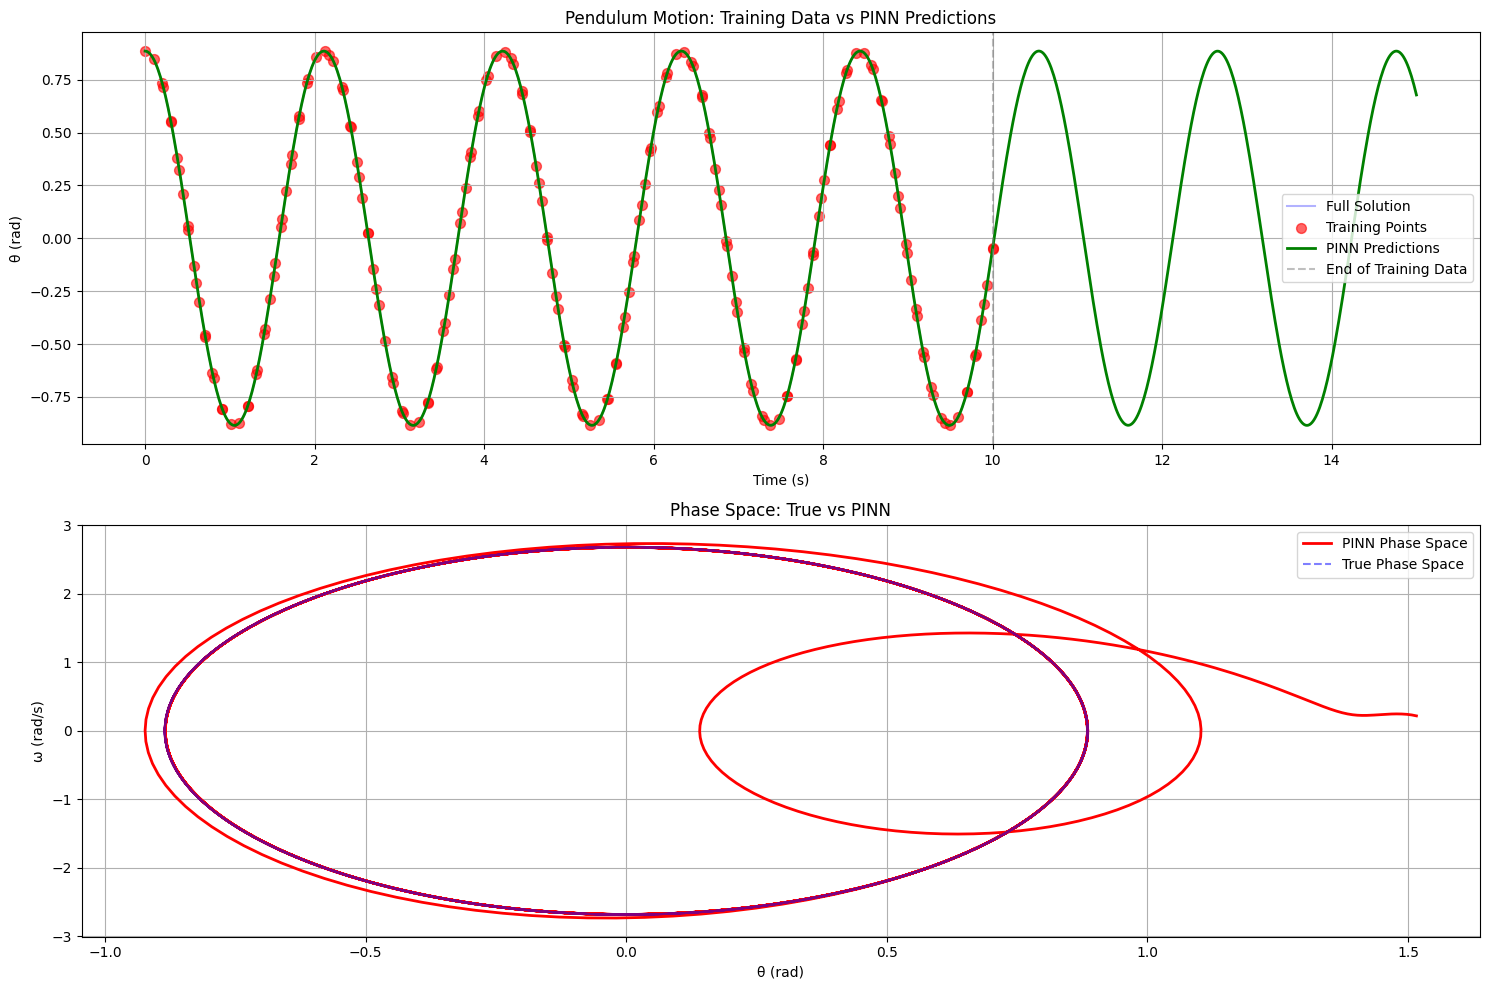


MSE on training time span: 0.000000


In [4]:
# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Generate data
L = 1.0
g = 9.81
theta0 = np.pi/4 + 0.1
omega0 = 0
t_span = (0, 10)
num_points = 10000
training_points = 200

# Generate pendulum data
t_tensor, theta_tensor, omega_tensor, full_sol = generate_pendulum_data(
    L, g, theta0, omega0, t_span, num_points, training_points
)

# Create and train PINN
pinn = PendulumPINN(
    t_data=t_tensor,
    theta_data=theta_tensor,
    physics_weight=1.0,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Train
pinn.train(epochs=200000, print_every=1000)

# Generate predictions
t_pred = torch.linspace(0, 15, 1000, requires_grad=True).reshape(-1, 1)
predictions = pinn.predict(t_pred)

plt.figure(figsize=(15, 10))

# Original data and predictions
plt.subplot(2, 1, 1)
plt.plot(full_sol['t'], full_sol['theta'], 'b-', alpha=0.3, label='Full Solution')
plt.scatter(t_tensor.detach().numpy(), theta_tensor.numpy(), c='r', s=50,
           label='Training Points', alpha=0.6)
plt.plot(t_pred.detach().numpy(), predictions.detach().cpu().numpy(),
         'g-', label='PINN Predictions', linewidth=2)
plt.axvline(x=t_tensor[-1].item(), color='gray', linestyle='--',
            alpha=0.5, label='End of Training Data')
plt.xlabel('Time (s)')
plt.ylabel('θ (rad)')
plt.title('Pendulum Motion: Training Data vs PINN Predictions')
plt.legend()
plt.grid(True)

# Phase space - corrected version
plt.subplot(2, 1, 2)
# Create new tensors with requires_grad=True
t_phase = torch.linspace(0, 20, 1000, requires_grad=True, device=pinn.device).reshape(-1, 1)
with torch.set_grad_enabled(True):
    pred_phase = pinn.model(t_phase)
    omega_pred = pinn.compute_derivatives(t_phase, pred_phase)[0]

plt.plot(pred_phase.detach().cpu().numpy(),
         omega_pred.detach().cpu().numpy(),
         'r-', label='PINN Phase Space', linewidth=2)
plt.plot(full_sol['theta'], full_sol['omega'],
         'b--', alpha=0.5, label='True Phase Space')
plt.xlabel('θ (rad)')
plt.ylabel('ω (rad/s)')
plt.title('Phase Space: True vs PINN')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Optional: Print some metrics
t_eval = torch.linspace(0, t_span[1], 1000, requires_grad=True, device=pinn.device).reshape(-1, 1)
with torch.set_grad_enabled(True):
    pred_eval = pinn.model(t_eval)
    true_eval = torch.tensor(np.interp(t_eval.cpu().detach().numpy(),
                                     full_sol['t'],
                                     full_sol['theta']),
                           device=pinn.device)
    mse = torch.mean((pred_eval - true_eval)**2)
    print(f"\nMSE on training time span: {mse.item():.6f}")

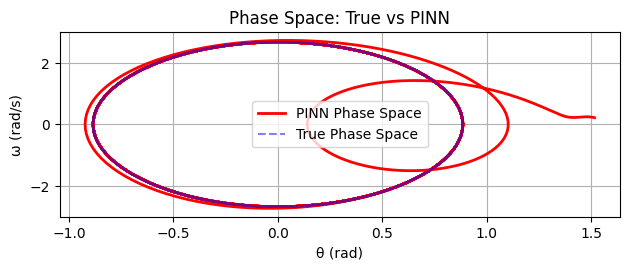

In [5]:
plt.subplot(2, 1, 2)
# Create new tensors with requires_grad=True
t_phase = torch.linspace(0, 20, 1000, requires_grad=True, device=pinn.device).reshape(-1, 1)
with torch.set_grad_enabled(True):
    pred_phase = pinn.model(t_phase)
    omega_pred = pinn.compute_derivatives(t_phase, pred_phase)[0]

plt.plot(pred_phase.detach().cpu().numpy(),
         omega_pred.detach().cpu().numpy(),
         'r-', label='PINN Phase Space', linewidth=2)
plt.plot(full_sol['theta'], full_sol['omega'],
         'b--', alpha=0.5, label='True Phase Space')
plt.xlabel('θ (rad)')
plt.ylabel('ω (rad/s)')
plt.title('Phase Space: True vs PINN')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


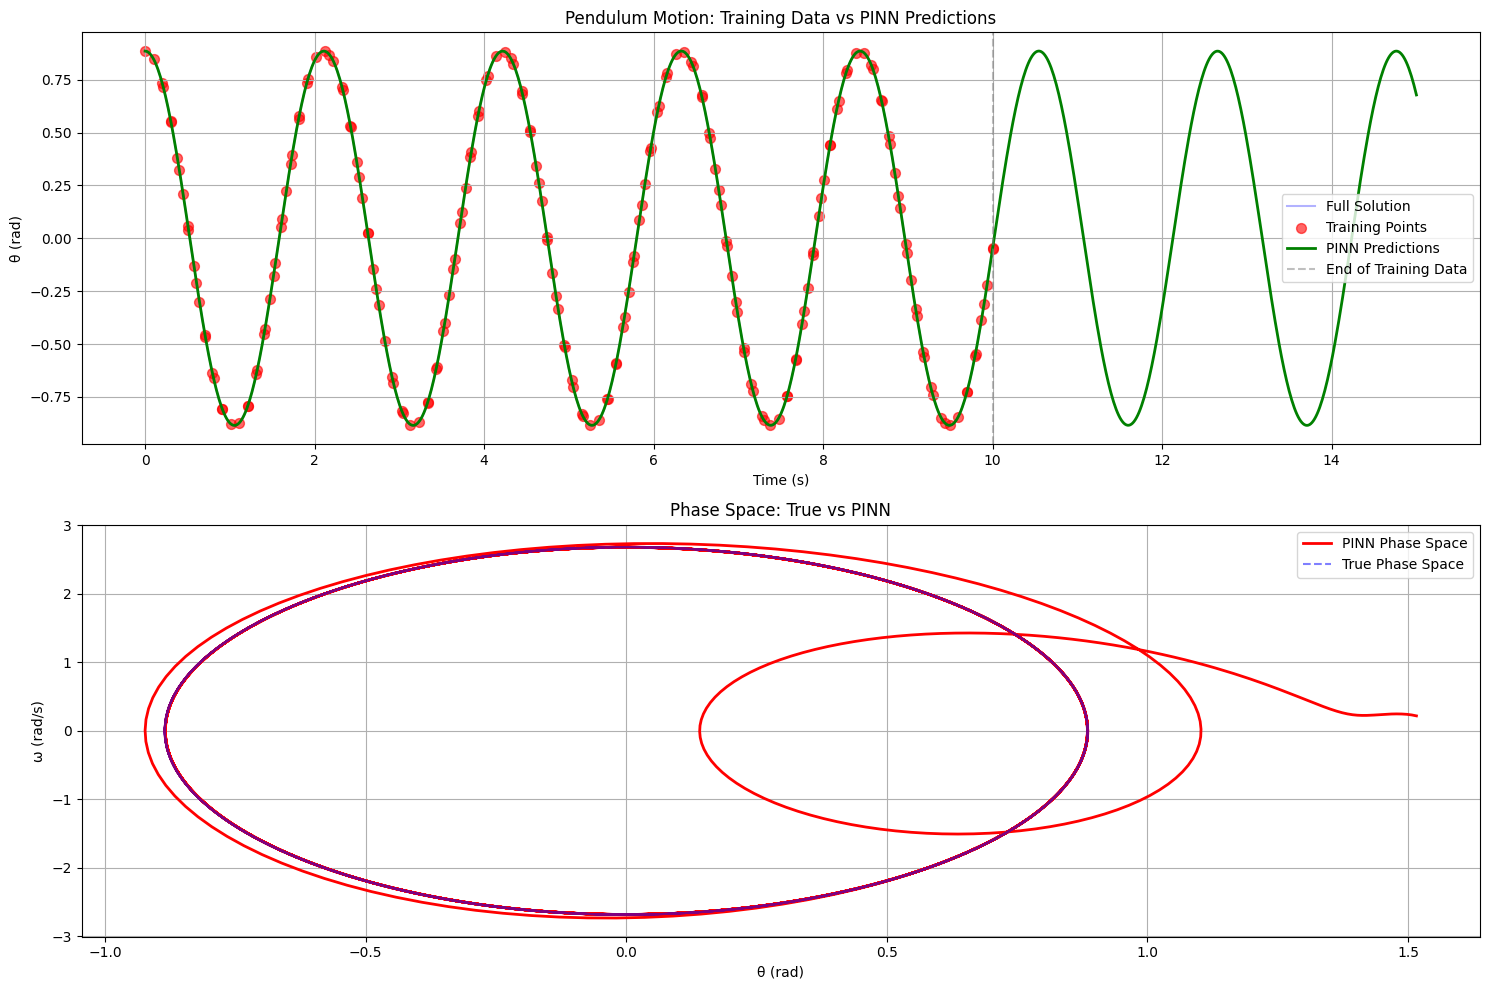


MSE on training time span: 0.000000


In [6]:

plt.figure(figsize=(15, 10))

# Original data and predictions
plt.subplot(2, 1, 1)
plt.plot(full_sol['t'], full_sol['theta'], 'b-', alpha=0.3, label='Full Solution')
plt.scatter(t_tensor.detach().numpy(), theta_tensor.numpy(), c='r', s=50,
           label='Training Points', alpha=0.6)
plt.plot(t_pred.detach().numpy(), predictions.detach().cpu().numpy(),
         'g-', label='PINN Predictions', linewidth=2)
plt.axvline(x=t_tensor[-1].item(), color='gray', linestyle='--',
            alpha=0.5, label='End of Training Data')
plt.xlabel('Time (s)')
plt.ylabel('θ (rad)')
plt.title('Pendulum Motion: Training Data vs PINN Predictions')
plt.legend()
plt.grid(True)

# Phase space - corrected version
plt.subplot(2, 1, 2)
# Create new tensors with requires_grad=True
t_phase = torch.linspace(0, 20, 1000, requires_grad=True, device=pinn.device).reshape(-1, 1)
with torch.set_grad_enabled(True):
    pred_phase = pinn.model(t_phase)
    omega_pred = pinn.compute_derivatives(t_phase, pred_phase)[0]

plt.plot(pred_phase.detach().cpu().numpy(),
         omega_pred.detach().cpu().numpy(),
         'r-', label='PINN Phase Space', linewidth=2)
plt.plot(full_sol['theta'], full_sol['omega'],
         'b--', alpha=0.5, label='True Phase Space')
plt.xlabel('θ (rad)')
plt.ylabel('ω (rad/s)')
plt.title('Phase Space: True vs PINN')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Optional: Print some metrics
t_eval = torch.linspace(0, t_span[1], 1000, requires_grad=True, device=pinn.device).reshape(-1, 1)
with torch.set_grad_enabled(True):
    pred_eval = pinn.model(t_eval)
    true_eval = torch.tensor(np.interp(t_eval.cpu().detach().numpy(),
                                     full_sol['t'],
                                     full_sol['theta']),
                           device=pinn.device)
    mse = torch.mean((pred_eval - true_eval)**2)
    print(f"\nMSE on training time span: {mse.item():.6f}")